In [40]:
#!pip install --upgrade setuptools --ignore-installed
#!pip install tensorflow
#!pip install keras
#!pip install keras.utils.to_categorical

In [41]:
import cv2
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from keras import preprocessing, utils, models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten,  Dense
import mahotas as mh
import scipy.stats
from skimage import io, color, util, filters, measure

In [42]:
# Initialising dataset and label lists
dataset = []
label = []
# Setting the input size for the model
input_size = 64
# Defining the labels for the four types of tumors
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [43]:
# Loading and preprocessing the training images
for i in labels:
    datasets_path = 'data/Training/' + i
    for j in os.listdir(datasets_path):
        img = cv2.imread(os.path.join(datasets_path, j))
        img = cv2.resize(img, (input_size, input_size))
        dataset.append(np.array(img))
        label.append(i)

# Loading and preprocessing the testing images
for i in labels:
    datasets_path = 'data/Testing/' + i
    for j in os.listdir(datasets_path):
        img = cv2.imread(os.path.join(datasets_path, j))
        img = cv2.resize(img, (input_size, input_size))
        dataset.append(np.array(img))
        label.append(i)

In [44]:
# Converting the dataset and label lists to numpy arrays
dataset = np.array(dataset)
label = np.array(label)

In [45]:
# Shuffling the dataset and labels
dataset, label = shuffle(dataset, label, random_state=150)
# Printing the shape of the dataset
dataset.shape

(3264, 64, 64, 3)

In [46]:
# Splitting the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=150)

# Printing the shape of the training set
print( x_train.shape)
print(y_train.shape)
# Printing the shape of the testing set
print(x_test.shape)
print(y_test.shape)

(2611, 64, 64, 3)
(2611,)
(653, 64, 64, 3)
(653,)


In [47]:
# Converting the labels to integers and then to categorical format
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train=y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test=y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [48]:
model = Sequential()
model.add(Conv2D(32,(3,3),activation = 'relu',input_shape=(input_size,input_size,3)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(4,activation='softmax'))

In [49]:
# Printing the model architectural summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 26, 26, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 348,740 (1.33 MB)

 Trainable params: 348,740 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Visualising the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [51]:
# Compiling the model
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])
# Training the model
history = model.fit(x_train, y_train, epochs=10, validation_split=0.1, verbose=2)

Epoch 1/10
74/74 - 17s - 236ms/step - accuracy: 0.3563 - loss: 1.4625 - val_accuracy: 0.4466 - val_loss: 1.1795
Epoch 2/10
74/74 - 14s - 191ms/step - accuracy: 0.5151 - loss: 1.0884 - val_accuracy: 0.5534 - val_loss: 1.0811
Epoch 3/10
74/74 - 14s - 186ms/step - accuracy: 0.6224 - loss: 0.8866 - val_accuracy: 0.6756 - val_loss: 0.8052
Epoch 4/10
74/74 - 14s - 183ms/step - accuracy: 0.7114 - loss: 0.7110 - val_accuracy: 0.7023 - val_loss: 0.7474
Epoch 5/10
74/74 - 13s - 181ms/step - accuracy: 0.7782 - loss: 0.5493 - val_accuracy: 0.7939 - val_loss: 0.5440
Epoch 6/10
74/74 - 14s - 185ms/step - accuracy: 0.8340 - loss: 0.4221 - val_accuracy: 0.8359 - val_loss: 0.5142
Epoch 7/10
74/74 - 20s - 271ms/step - accuracy: 0.8799 - loss: 0.3227 - val_accuracy: 0.8397 - val_loss: 0.5157
Epoch 8/10
74/74 - 14s - 188ms/step - accuracy: 0.9259 - loss: 0.2135 - val_accuracy: 0.8664 - val_loss: 0.3986
Epoch 9/10
74/74 - 13s - 180ms/step - accuracy: 0.9464 - loss: 0.1515 - val_accuracy: 0.8702 - val_loss:

In [52]:
# Evaluating the model on the training data
eval_model_on_trainedData=model.evaluate(x_train, y_train)

# Printing the evaluation results for the training data
eval_model_on_trainedData

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9686 - loss: 0.0973


[0.13762010633945465, 0.9574875235557556]

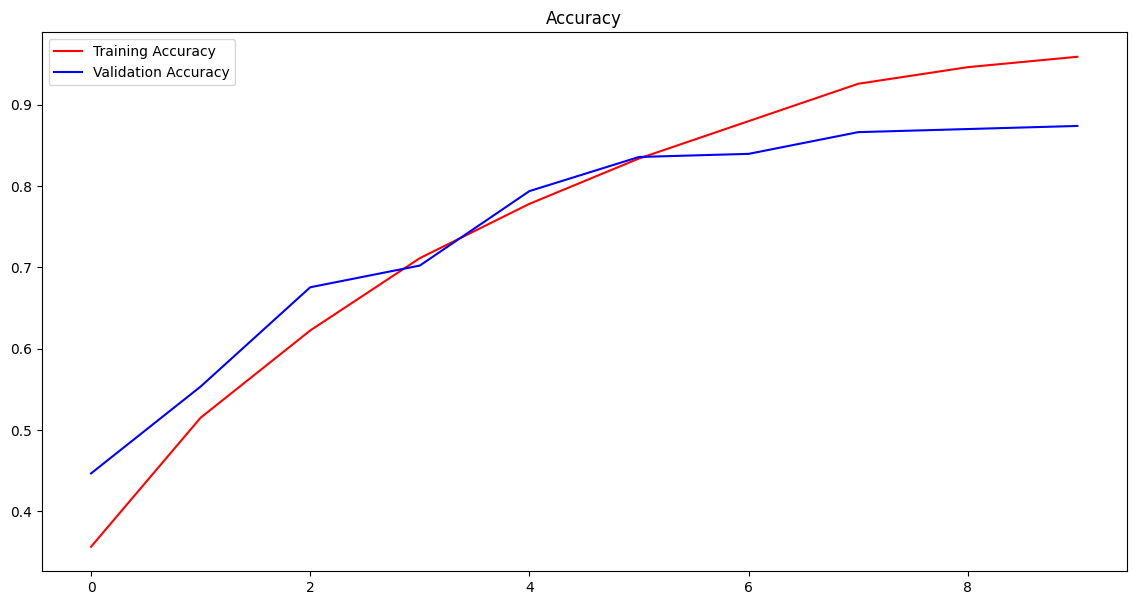

In [53]:
# Extracting accuracy history from the model's training history
acc = history.history['accuracy']
# Extracting validation accuracy history from the model's training history
val_acc = history.history['val_accuracy']
# Creating a range object that represents the number of completed epochs
epochs = range(len(acc))
# Creating a new figure for plotting
fig = plt.figure(figsize=(14,7))
#Printing the Tittle of the graph being plotted
plt.title('Accuracy')
# Plotting the training accuracy
plt.plot(epochs,acc,'r',label="Training Accuracy")
# Plotting the validation accuracy
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
# Adding a legend to the plot
plt.legend(loc='upper left')
# Displaying the plot
plt.show()

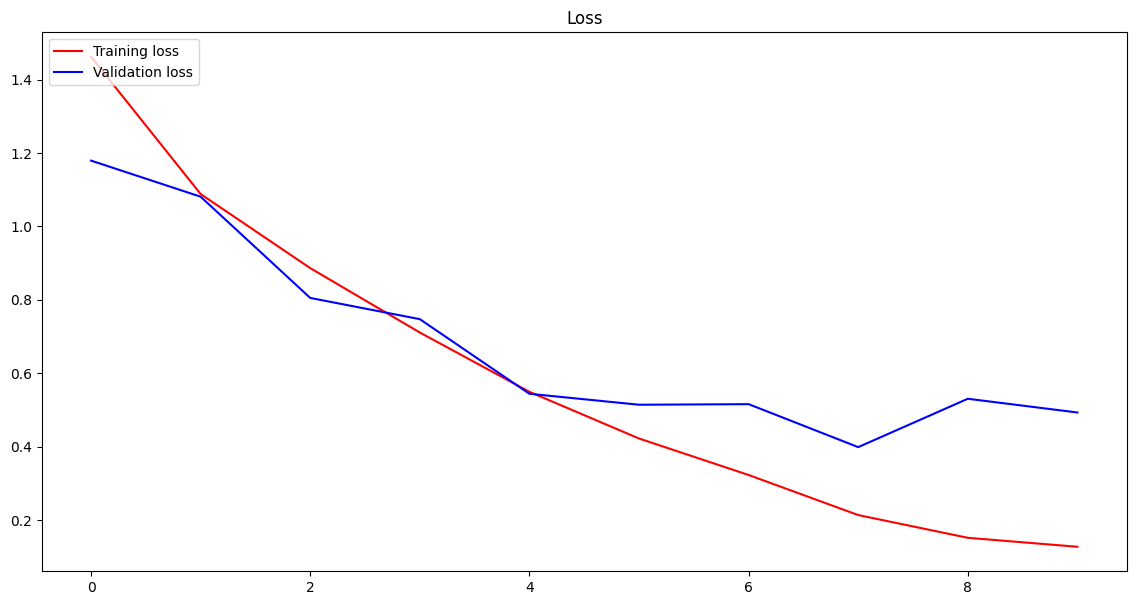

In [54]:
loss = history.history['loss']
# Extracting validation loss history from the model's training history
val_loss = history.history['val_loss']
# Creating a range object that represents the number of completed epochs (same as before)
epochs = range(len(loss))
# Creating a new figure for plotting
fig = plt.figure(figsize=(14,7))
#Printing the Tittle of the graph being plotted
plt.title('Loss')
# Plotting the training loss
plt.plot(epochs,loss,'r',label="Training loss")
# Plotting the validation loss
plt.plot(epochs,val_loss,'b',label="Validation loss")
# Adding a legend to the plot
plt.legend(loc='upper left')
# Displaying the plot
plt.show()

In [55]:
# Loading the image and mask in grayscale
mri_image = cv2.imread('data/Training/meningioma_tumor/m (109).jpg', cv2.IMREAD_GRAYSCALE)
mask = cv2.imread('data/Training/meningioma_tumor/m (109).jpg', cv2.IMREAD_GRAYSCALE)

In [56]:
# Loading the image in color
img = cv2.imread('data/Training/meningioma_tumor/m (109).jpg')

In [57]:
# Resizing the image for prediction
img = cv2.resize(img, (64, 64))
img_array = img.reshape(1, 64, 64, 3)


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [ ]:
# Predicting the type of tumor
tdc=model.predict(img_array)
indices = tdc.argmax()
type = indices
if indices==0:
    type = "Glioma Tumour"
elif indices==1:
    type = "Meningioma Tumour"
elif indices==2:
    type = "Healthy Brain"
else:
    type = "Pituitary Tumour"

In [ ]:
# Creating a binary mask and a segmented image
_, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
highlighted = cv2.addWeighted(mri_image, 0.7, binary_mask, 0.3, 0)

In [ ]:
# Plotting the original and segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mri_image, cmap='gray')
plt.title('Original MRI Image')
plt.subplot(1, 2, 2)
plt.imshow(highlighted, cmap='gray')
plt.title('Highlighted Image')
plt.show()

# Ensuring the mask is binary
mask = mask > filters.threshold_otsu(mask)

# Extracting the tumor region
tumor_region= np.where(mask, mri_image, 0)

# Calculating the features
mean = np.mean(tumor_region)
std_dev = np.std(tumor_region)
entropy = measure.shannon_entropy(tumor_region)
rms = np.sqrt(np.mean(tumor_region**2))
variance = np.var(tumor_region)
smoothness = 1 - 1 / (1 + variance)
kurtosis = scipy.stats.kurtosis(tumor_region.flatten())
skewness = scipy.stats.skew(tumor_region.flatten())

# Calculating the Haralick features
haralick_features = mh.features.haralick(tumor_region.astype(int))
contrast = haralick_features[:, 1]
correlation = haralick_features[:, 2]
energy = haralick_features[:, 4]
homogeneity = haralick_features[:, 8]

# Printing the classification and features
print(f'Classification: {type}\n\n')
print(f"Mean: {mean}")
print(f"Standard Deviation: {std_dev}")
print(f"Entropy: {entropy}")
print(f"RMS: {rms}")
print(f"Variance: {variance}")
print(f"Smoothness: {smoothness}")
print(f"Kurtosis: {kurtosis}")
print(f"Skewness: {skewness}")
print(f"Contrast: {contrast}")
print(f"Correlation: {correlation}")
print(f"Energy: {energy}")
print(f"Homogeneity: {homogeneity}")